In [19]:
NUMBER_OF_EPOCH = 5000
# num_of_categories = 

In [20]:
import torch
import torch.nn as nn
import pandas as pd
import preprocessing as pp
import numpy as np 
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import pickle

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.backends.cuda.is_built():
    mps_device = torch.device("cuda")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [21]:
def data_preprocessing(df):
    df = df.drop(['manufacturer'], axis=1)
    df = df.drop(['id'], axis=1)
    
    df = pp.standardize(df)
    df = pp.encoder(df)
    with_outliers_df = df
    df = pp.outlier_removal(df)
    
    train, val = train_test_split(df, test_size=0.10)

    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)

    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
        
    return X_train, y_train, X_val, y_val, with_outliers_df

In [22]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(8, 1024),
        nn.Dropout(0.1),
        nn.ReLU(), 

        nn.Linear(1024, 128),
        nn.ReLU(), 
        
        nn.Linear(128, 80),
        nn.ReLU(),
        
        nn.Linear(80, 16),
        nn.ReLU(),
        
        nn.Linear(16, 1)
        )
        
        self.model_layer = nn.Sequential(
        nn.Linear(169, 1),
        nn.ReLU()
        )
        
        self.gear_box_layer = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type_layer = nn.Sequential( 
        nn.Linear(5, 1),
        nn.ReLU()
        )
        
    def forward(self, x):
        # print(x.shape)
        model = self.model_layer(x[:, 5:174])
        gear_box = self.gear_box_layer(x[:, 174:177])
        fuel_type = self.fuel_type_layer(x[:, 177:182])
        
        # registration_fee = self.registration_fee_layer(x[:, 156:164])
        # engine_capacity = self.engine_capacity_layer(x[:, 164:174])
        # operating_hours = x[:, 174].view(-1, 1)
        # year = x[:, 175].view(-1, 1)
        # efficiency = x[:, 176].view(-1, 1)

        
        # x = torch.cat((model, year, gear_box, operating_hours, fuel_type, registration_fee, efficiency, engine_capacity), 1)
        
        x = torch.cat((model, gear_box, fuel_type, x[:, :5]), 1)
        
        return self.layers(x)

model = mlp()
writer = SummaryWriter()
writer.add_graph(model, torch.rand(1, 182))

In [23]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))
    
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [24]:
df = pd.read_csv('data/org_train.csv')
X_train, y_train, X_val, y_val, with_outlier = data_preprocessing(df)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

list_of_model shape: (169,)
list_of_gearbox_type shape: (3,)
list_of_fuel_type shape: (5,)
Inliers: (9900, 183)
torch.Size([8910, 182]) torch.Size([8910]) torch.Size([990, 182]) torch.Size([990])


In [25]:
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val).item()
    validation_loss = np.append(validation_loss, val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
        
    y_pred = model(X_train)[:, 0]
    training_loss_eval = loss_fn(y_pred, y_train).item()
    training_loss = np.append(training_loss, training_loss_eval)
    
    if n % 100 == 0:
        print(f'Epoch: {n} Training loss:  {training_loss_eval}'f' Validation loss: {val_loss}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss

Epoch: 0 Training loss:  19540.8515625 Validation loss: 19217.80859375 best Validation loss: 19217.80859375
Epoch: 100 Training loss:  11453.2216796875 Validation loss: 11271.27734375 best Validation loss: 11271.27734375
Epoch: 200 Training loss:  4728.375 Validation loss: 4853.28564453125 best Validation loss: 4853.28564453125
Epoch: 300 Training loss:  3787.578857421875 Validation loss: 3839.755126953125 best Validation loss: 3839.755126953125
Epoch: 400 Training loss:  3142.274169921875 Validation loss: 3214.728759765625 best Validation loss: 3214.728759765625
Epoch: 500 Training loss:  2885.9013671875 Validation loss: 2888.491455078125 best Validation loss: 2884.75927734375
Epoch: 600 Training loss:  2796.36279296875 Validation loss: 2729.180419921875 best Validation loss: 2724.1162109375
Epoch: 700 Training loss:  2750.00048828125 Validation loss: 2636.696533203125 best Validation loss: 2633.33837890625
Epoch: 800 Training loss:  2720.586181640625 Validation loss: 2578.0078125 bes

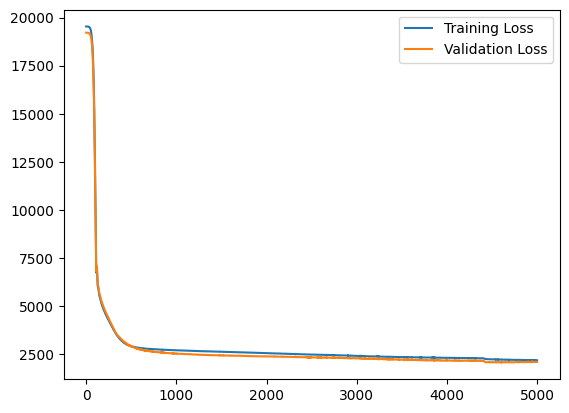

In [26]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [27]:
df = pd.read_csv('data/org_test.csv')
model = torch.load('mlp_model.pth', weights_only=False)
model.eval()
index = df['id']
df = df.drop(['id'], axis=1)
df = df.drop(['manufacturer'], axis=1)
df = pp.standardize(df, pickle.load(open('scaler.pkl', 'rb'))) 
df = pp.encoder(df, pickle.load(open('encoder.pkl', 'rb')))
X = torch.tensor(df.values, dtype=torch.float32)
y_pred = model(X)[:, 0]


df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

y = with_outlier['price'].values
X = with_outlier.drop(['price'], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]
loss = loss_fn(y_pred, torch.tensor(y, dtype=torch.float32)).item()
print(f'Loss: {loss}')

Loss: 2202.62353515625
